<a href="https://colab.research.google.com/github/03axdov/Notebooks/blob/main/CatsVsDogsTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True
)

print(f"Training samples: {tf.data.experimental.cardinality(train_ds)}")
print(f"Validation samples: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Test samples: {tf.data.experimental.cardinality(test_ds)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteU206T7/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Training samples: 9305
Validation samples: 2326
Test samples: 2326


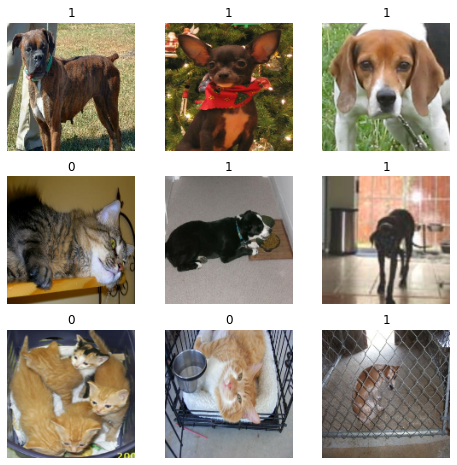

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for i, (image, label) in enumerate(train_ds.take(9)):
  plt.subplot(3,3,i+1)
  image = tf.image.resize(image, (150,150))
  image = tf.cast(image, tf.uint8)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

In [4]:
size = (150,150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
BATCH_SIZE = 32

train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

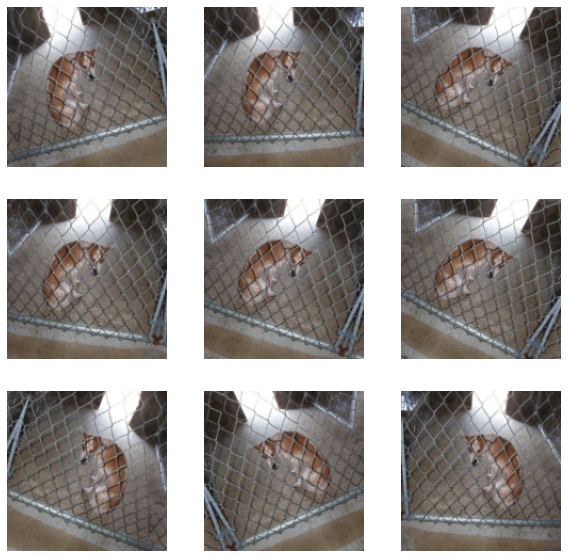

In [7]:
for images, labels in train_ds.take(1):
  plt.figure(figsize=(10,10))
  first_image = images[0]
  for i in range(9):
    plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0), training=True)
    augmented_image = tf.cast(augmented_image, tf.uint8)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [8]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",
    input_shape=(150,150,3),
    include_top=False
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(150,150,3))
x = data_augmentation(inputs)

scale_layer = layers.Rescaling(2/255.0, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

83697664/83683744 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [11]:
EPOCHS = 20
model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds
)

Epoch 1/20
291/291 [==============================] - 41s 86ms/step - loss: 0.1640 - binary_accuracy: 0.9309 - val_loss: 0.0809 - val_binary_accuracy: 0.9690
Epoch 2/20
291/291 [==============================] - 23s 78ms/step - loss: 0.1160 - binary_accuracy: 0.9508 - val_loss: 0.0758 - val_binary_accuracy: 0.9678
Epoch 3/20
291/291 [==============================] - 22s 75ms/step - loss: 0.1096 - binary_accuracy: 0.9548 - val_loss: 0.0725 - val_binary_accuracy: 0.9725
Epoch 4/20
291/291 [==============================] - 22s 77ms/step - loss: 0.1038 - binary_accuracy: 0.9560 - val_loss: 0.0713 - val_binary_accuracy: 0.9695
Epoch 5/20
291/291 [==============================] - 23s 79ms/step - loss: 0.1086 - binary_accuracy: 0.9553 - val_loss: 0.0792 - val_binary_accuracy: 0.9686
Epoch 6/20
291/291 [==============================] - 23s 81ms/step - loss: 0.1006 - binary_accuracy: 0.9574 - val_loss: 0.0755 - val_binary_accuracy: 0.9703
Epoch 7/20
291/291 [==============================] 

In [12]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

EPOCHS = 10

model.fit(
    train_ds, epochs=EPOCHS, validation_data=validation_ds
)

Epoch 1/10
291/291 [==============================] - 96s 306ms/step - loss: 0.0753 - binary_accuracy: 0.9716 - val_loss: 0.0559 - val_binary_accuracy: 0.9789
Epoch 2/10
291/291 [==============================] - 87s 300ms/step - loss: 0.0563 - binary_accuracy: 0.9766 - val_loss: 0.0517 - val_binary_accuracy: 0.9794
Epoch 3/10
291/291 [==============================] - 87s 299ms/step - loss: 0.0455 - binary_accuracy: 0.9819 - val_loss: 0.0464 - val_binary_accuracy: 0.9807
Epoch 4/10
291/291 [==============================] - 87s 299ms/step - loss: 0.0378 - binary_accuracy: 0.9859 - val_loss: 0.0504 - val_binary_accuracy: 0.9802
Epoch 5/10
291/291 [==============================] - 87s 300ms/step - loss: 0.0283 - binary_accuracy: 0.9893 - val_loss: 0.0496 - val_binary_accuracy: 0.9815
Epoch 6/10
291/291 [==============================] - 87s 299ms/step - loss: 0.0216 - binary_accuracy: 0.9915 - val_loss: 0.0491 - val_binary_accuracy: 0.9798
Epoch 7/10
291/291 [==========================